In [1]:
from pytorch_grad_cam import GradCAM
from src.data.dataset import load_dataset
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch
from torchvision import transforms
from gradcam.utils import visualize_cam
from src.models.models import SNeurodCNN
import matplotlib.pyplot as plt
import numpy as np

classes = ('CN', 'AD', 'MCI')

id2label = {i: classes[i] for i in range(len(classes))}
label2id = {classes[i]: i for i in range(len(classes))}
trainset, testset, valset = load_dataset(label2id=label2id)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=0)


#load model
model = SNeurodCNN()
model.load_state_dict(torch.load('./models/sneurod_cnn.pth'))
model.eval()

# Define transformations for input images
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((180, 180)),  
    transforms.ToTensor(),  
])

# Randomly select 6 images from the test set
selected_images = []
selected_labels = []
for i, data in enumerate(testloader, 0):
    images, labels = data
    selected_images.append(images[0])
    selected_labels.append(labels[0])
    if len(selected_images) == 6:
        break
    
# target layer is the last convolution layer
target_layers = [model.conv3]
cam = GradCAM(model=model, target_layers=target_layers)


In [2]:
model.conv3

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))

In [3]:
selected_labels

[tensor(0), tensor(2), tensor(0), tensor(0), tensor(2), tensor(0)]

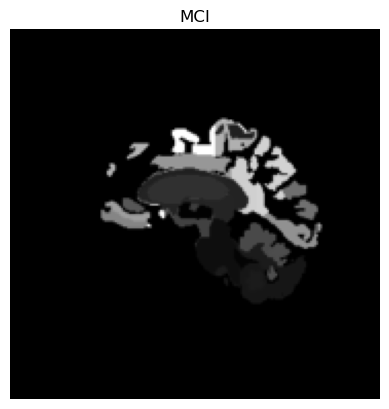

In [4]:
# Visualize one selected image
plt.imshow(selected_images[4].squeeze(0), cmap='gray')  
plt.axis('off')
plt.title('MCI')
plt.show()


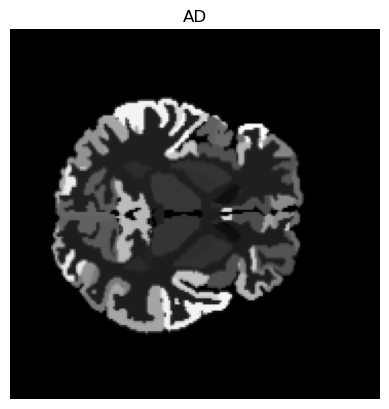

In [5]:
# Visualize one selected image
plt.imshow(selected_images[2].squeeze(0), cmap='gray')  
plt.axis('off')
plt.title('AD')
plt.show()

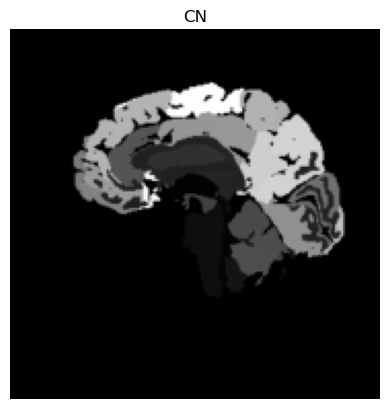

In [6]:
# Visualize one selected image
plt.imshow(selected_images[3].squeeze(0), cmap='gray')  
plt.axis('off')
plt.title('CN')
plt.show()

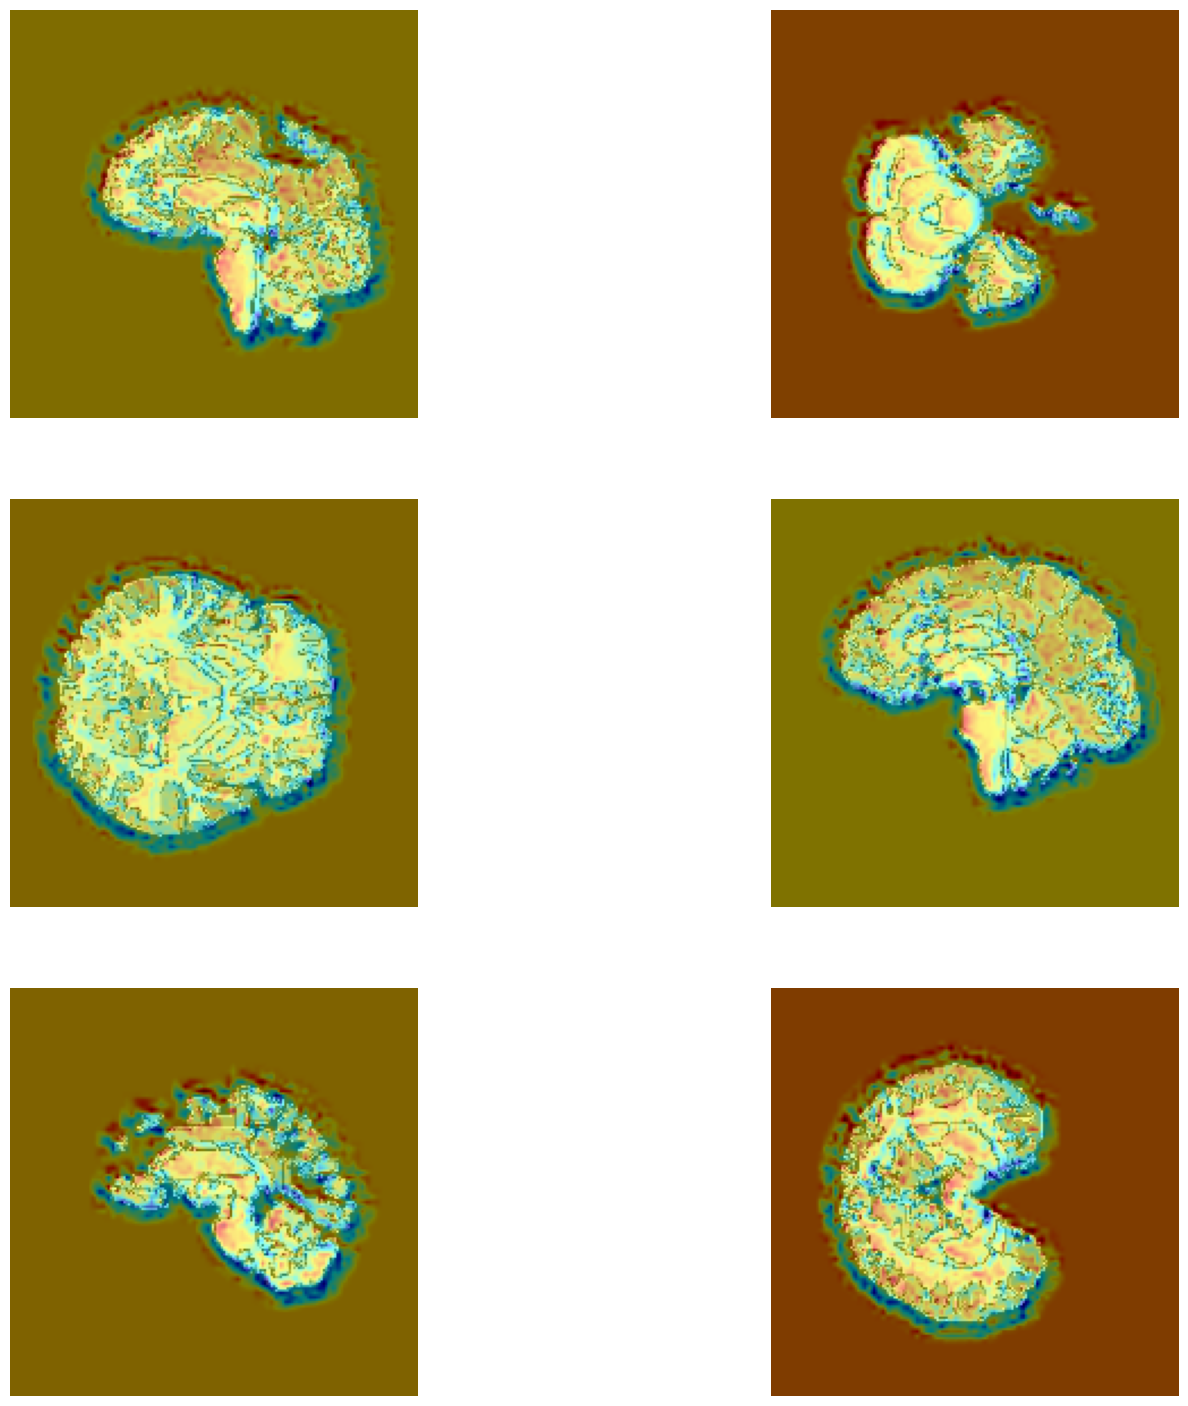

In [8]:
from PIL import Image

def visualize_gradcam(model, cam, image_paths, transform):
    model.eval()
    fig, ax = plt.subplots(3, 2, figsize=(18,18))
    for i, image in enumerate(image_paths):
        row = i // 2
        col = i % 2
        image = transform(image).unsqueeze(0)
        with torch.no_grad():
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)
        
        grayscale_cam = cam(input_tensor=image, targets=None)
        grayscale_cam = grayscale_cam[0, :]

        # Check if the image tensor is already a 2D tensor (grayscale) or a 3D tensor (color)
        if image.squeeze(0).ndim == 3:
            image_np = np.array(image.squeeze(0).permute(1, 2, 0), dtype=np.float32)  # Permute if it has 3 dimensions
        elif image.squeeze(0).ndim == 2:
            image_np = np.array(image.squeeze(0), dtype=np.float32)  # Use directly if it's 2D
        else:
            raise ValueError("Unsupported image dimensionality")

        image_np /= image_np.max()  # Normalize to range [0, 1]

        resized_cam = np.array(Image.fromarray(grayscale_cam).resize(image_np.shape[:2][::-1]))

        # If image is grayscale but expected to be color for visualization:
        if image_np.ndim == 2:
            image_np = np.stack([image_np]*3, axis=-1)  # Convert to RGB by repeating the grayscale channel

        visualization = show_cam_on_image(image_np, resized_cam, use_rgb=True)
        ax[row, col].imshow(visualization)
        ax[row, col].axis('off')
    
    plt.show()


visualize_gradcam(model, cam, selected_images, transform)

In [ ]:
# Building GradCAM from scratch

# Define the hook to capture the feature map and gradients
class SaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output
    def close(self):
        self.hook.remove()

# Define the GradCAM function
def grad_cam(model, img, target_layer):
    # Set the model to evaluation mode
    model.eval()
    # Define the image transformation pipeline
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    # Preprocess the image
    img_tensor = preprocess(img).unsqueeze(0)
    # Create a tensor for the gradients
    img_tensor.requires_grad_()
    
    # Forward pass
    output = model(img_tensor)
    # Calculate the gradients
    model.zero_grad()
    # Get the index corresponding to the highest score
    pred_idx = output.argmax(dim=1)
    # Backward pass to calculate gradients
    output[:, pred_idx].backward()
    
    # Get the gradients of the target layer
    gradients = model.conv3.weight.grad
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    
    # Get the activations of the target layer
    activations = model.conv3(img_tensor)
    activations = activations.squeeze(0)
    # Weight the activations by the gradients
    for i in range(activations.size(0)):
        activations[i, ...] *= pooled_gradients[i]
    
    # Calculate the heatmap
    heatmap = torch.mean(activations, dim=0).detach().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    return heatmap

img_pil = transforms.ToPILImage()(selected_images[3].squeeze().detach().cpu())

# Get the GradCAM heatmap
heatmap = grad_cam(model, img_pil, model.conv3)

# Visualize the heatmap
plt.imshow(heatmap, cmap='jet')
plt.axis('off')
plt.show()